# Using pre-trained model and fine-tuning

In [2]:
pip install tensorflow==2.6.0

  Using cached tensorflow-2.6.0-cp36-cp36m-manylinux2010_x86_64.whl (458.3 MB)
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.2
    Uninstalling tensorflow-2.6.2:
      Successfully uninstalled tensorflow-2.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-serving-api 2.1.0 requires tensorflow~=2.1.0, but you have tensorflow 2.6.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from PIL import Image

In [3]:
print(f"tensorflow version {tf.__version__}")
tf.test.is_gpu_available(cuda_only=True)

tensorflow version 2.6.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## Working with pre-trained resnet

In [123]:
resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000)

In [124]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

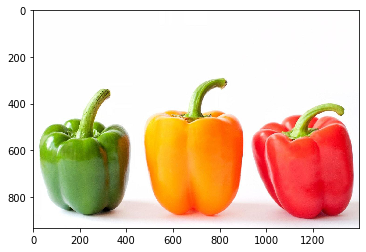

In [125]:
im = Image.open("peppers.jpeg")
im_arr = np.array(im)
plt.imshow(im_arr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


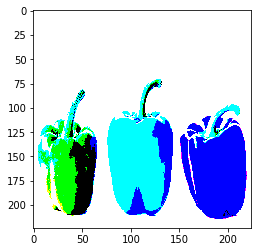

In [140]:
# pre-process the image and resize to appropriate size
im_arr2 = tf.keras.applications.resnet50.preprocess_input(im_arr)
im_arr3 = tf.image.resize(im_arr2,[224,224],method="nearest")
plt.imshow(im_arr3)

In [141]:
im_arr3 = tf.reshape(im_arr3,[1,224,224,3])
result = resnet50.predict(im_arr3)
label = tf.keras.applications.imagenet_utils.decode_predictions(result)
label

[[('n07720875', 'bell_pepper', 0.9994469),
  ('n07718472', 'cucumber', 0.00038280207),
  ('n07716358', 'zucchini', 6.547548e-05),
  ('n07717410', 'acorn_squash', 4.0954987e-05),
  ('n07716906', 'spaghetti_squash', 1.37495845e-05)]]

In [ ]:
## try adversarial attack changing pepper to goldfish (class label 1)

In [139]:
tf.keras.applications.imagenet_utils.decode_predictions(tf.one_hot(1,depth=1000).numpy().reshape(1,1000))

[[('n01443537', 'goldfish', 1.0),
  ('n15075141', 'toilet_tissue', 0.0),
  ('n02319095', 'sea_urchin', 0.0),
  ('n02395406', 'hog', 0.0),
  ('n02391049', 'zebra', 0.0)]]

## Fine-tuning resnet50 to perform dog image classification

In [46]:
from tensorflow import keras
from tensorflow.keras import layers

In [82]:
# create an on-the-fly dataset
# the directory has to be split by class, each class in each subdirectory

# this data gen object split validation for us
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

# this is an iterator with subset = training
train_dataset = train_datagen.flow_from_directory("/home/ec2-user/tf2/images/Images", 
                class_mode="categorical",color_mode="rgb",batch_size =64,target_size=(224, 224),
                 shuffle=True, subset="training")

val_dataset = train_datagen.flow_from_directory("/home/ec2-user/tf2/images/Images", 
            class_mode="categorical",color_mode="rgb",batch_size =64,target_size=(224, 224),
                 shuffle=True, subset="validation")

data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),layers.RandomZoom(0.1),])

# pre-processing function needed for to be compatible with resnet 
def preprocessing(image, label):
    #image = image/255.0
    im2 = tf.keras.applications.resnet50.preprocess_input(image)
    im3 = tf.image.resize(im2,[224,224],method="nearest")
    im3 = data_augmentation(im3)
    #label = tf.one_hot(label,120)
    return im3, label
#train_dataset = train_dataset.map(lambda x,y: preprocessing(x,y))#.batch(32)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [93]:
# create layers that we want, note that we throw away the last prediction layer of resnet
# and we will swap in the last layer with 120 classes.

resnet50_new = tf.keras.applications.resnet50.ResNet50(include_top=False,
                 input_shape=(224,224,3), weights='imagenet')

x = resnet50_new.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)

In [156]:
# model is specified from the input node and the output node.
# instead of using compile method, we explicitly create loss function and optimizer
# 
model = tf.keras.models.Model(inputs=resnet50_new.input, outputs=predictions)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_list = []
list_accuracy = []

In [157]:
# set flag in all layers except the last layer to be non trainable
for i in model.layers[:-1]:
    i.trainable = False

In [158]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [159]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [160]:
# write explicit for loop instead of the fit method (this is much better for developing)
counter = 0
for inputs, target in train_dataset:
    inputs, target = preprocessing(inputs, target)
    with tf.GradientTape() as tape:
        pred = model(inputs, training=True) # pass through the model object and set training argument = True
        loss_value = loss_fn(target, pred) # calculate the loss value
    print(loss_value.numpy())
    loss_list.append(loss_value.numpy())
    pred_int = np.argmax(pred, axis=1)
    target_int = np.argmax(target,axis=1)
    list_accuracy.append(accuracy_score(pred_int, target_int))
    # tape the loss value to the trainable weight similar to backward prop
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # step the optimizer according to the learning rate set at the optimizer
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    counter += 1
    if counter == 200:
        break

1.3886621
1.5196656
1.5944071
1.553343
0.98288035
1.7059035
1.268795
1.2560515
1.3122469
1.6871117
1.1911597
1.4668394
1.1486167
1.5306089
1.1952591
1.0569613
1.455629
1.3010118
1.5400274
1.1560991
1.5925286
1.216193
1.0987375
1.1106616
1.14357
1.4047451
1.1870546
1.2170949
1.1561177
0.9394127
1.1354597
1.288991
1.2858751
1.2697046
1.2189536
1.0953565
0.9393398
1.0056517
1.3847344
1.2767239
1.5817215
1.0936112
1.0874937
1.305191
1.1482866
1.2655742
1.0598066
0.8446473
1.8327656
1.2127595
1.4498651
0.91024625
1.2472365
1.3084356
1.1756647
1.4716735
1.0553339
0.9454467
0.76638794
1.1474115
0.9611037
0.77747524
0.89634657
0.86943126
0.9856402
1.0646467
0.7667774
1.17086
0.6820774
0.8354527
1.1692235
0.7211869
0.9405629
0.9374256
1.1713002
1.0174263
0.97427595
0.98705256
0.7974472
1.1017749
0.9043602
1.1726036
1.2820296


KeyboardInterrupt: 

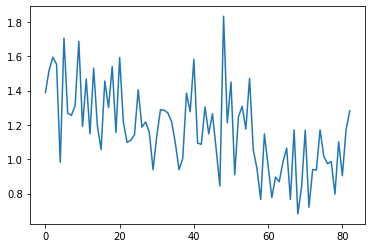

In [161]:
plt.plot(loss_list)

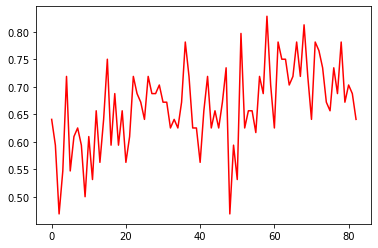

In [162]:
plt.plot(list_accuracy, color = "r")

### save the model and re-load the model

In [163]:
model.save("my_dog_classifier") # save model

INFO:tensorflow:Assets written to: my_dog_classifier/assets


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [164]:
new_model = keras.models.load_model("my_dog_classifier") # reload model with the same flag

In [165]:
new_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [166]:
val_accu = []
counter = 0
for inputs, target in val_dataset:
    inputs, target = preprocessing(inputs, target)
    with tf.GradientTape() as tape:
        pred = new_model(inputs, training=False)
        #loss_value = loss_fn(target, pred)
    #print(loss_value.numpy())
    #loss_list.append(loss_value.numpy())
    pred_int = np.argmax(pred, axis=1)
    target_int = np.argmax(target,axis=1)
    val_accu.append(accuracy_score(pred_int, target_int))
    counter += 1
    if counter == 10:
        break

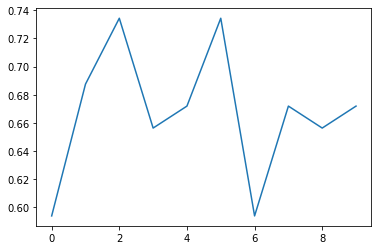

In [167]:
plt.plot(val_accu)

## Visualizing filters and feature maps

### visualizing filters

In [104]:
filters, biases = model.layers[2].get_weights() # return the 

In [106]:
filters.shape

(7, 7, 3, 64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

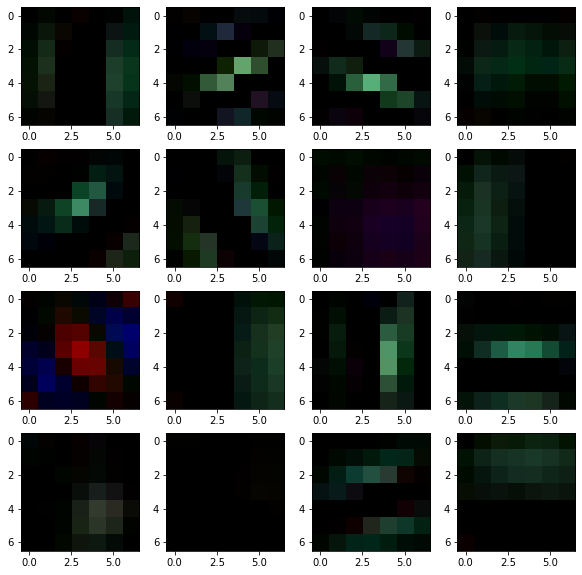

In [108]:
counter = 10
f, ax = plt.subplots(4,4, figsize=(10,10))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(filters[:,:,:,counter])
        counter += 1

### visualizing feature maps

In [110]:
# create a sub model that output the feature map that we want as output
submodel = tf.keras.models.Model(inputs=model.input, outputs=model.layers[2].output)

In [111]:
# then pass input through the sub model. the output is the feature map
for i in train_dataset:
    i = preprocessing(i[0],i[1])
    feature_maps = submodel.predict(i[0])
    break

In [112]:
feature_maps.shape

(64, 112, 112, 64)

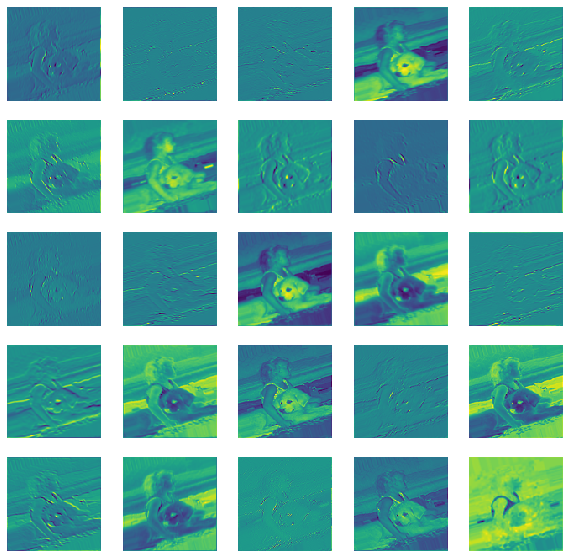

In [120]:
counter = 10
f, ax = plt.subplots(5,5, figsize=(10,10))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(feature_maps[0,:,:,counter])
        counter += 1
        ax[i,j].axis("off")